# Algoritma Deep Learning dengan Non Contextual Word Embedding (word2vec)

In [1]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import modules
# Ignore Warning
import warnings
warnings.filterwarnings(action = 'ignore')

# For data
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For processing
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# For word embedding
import gensim
from gensim.models import Word2Vec

# For deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# For evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load dataset
df_dev = pd.read_csv('data/dev.csv')
df_test = pd.read_csv('data/test.csv')
df_train = pd.read_csv('data/train.csv')

# df_dev = pd.read_csv('dev.csv')
# df_test = pd.read_csv('test.csv')
# df_train = pd.read_csv('train.csv')

In [4]:
df_train = df_train.drop('Unnamed: 0', axis=1)
df_train.sample(5)

,text_a,label
6825,langgar aturan psbb kapal pulau putar padang,no
2055,niceniecesix asli sedih dah kesel banget covid...,no
13600,kalo lucu kalo kaga emosi jiwa raga membara ka...,no
9072,mekanisme patofisiologi virus corona menginfek...,yes
3726,dennysiregar7 apapun kebijakan diambil pemerin...,no


## Preprocess Data

### Clean data

In [5]:
def preprocess_sentence(sentence, stopwords = None):
  # Clean links
  sentence = re.sub(r'http\S+', '', sentence)

  # Clean everything except alphabetical and numerical characters
  sentence = re.sub('[^a-zA-Z0-9]', ' ', sentence)

  # Tokenize
  tokenized_word = word_tokenize(sentence)

  # Remove stopwords
  if stopwords is not None:
    tokenized_word = [word for word in tokenized_word if word not in stopwords]
  
  # Join
  sentence = " ".join(tokenized_word)

  return sentence

In [6]:
list_stopword = stopwords.words("indonesian")

list_stopword

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apaan',
 'apabila',
 'apakah',
 'apalagi',
 'apatah',
 'artinya',
 'asal',
 'asalkan',
 'atas',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagian',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bakal',
 'bakalan',
 'balik',
 'banyak',
 'bapak',
 'baru',
 'bawah',
 'beberapa',
 'begini',
 'beginian',
 'beginikah',
 'beginilah',
 'begitu',
 'begitukah',
 'begitulah',
 'begitupun',
 'bekerja',
 'belakang',
 'belakangan',
 'belum',
 'belumlah',
 'benar',
 'benarkah',
 'benarlah',
 'berada',
 'berakhir',
 'berakhirlah',
 'berakhirnya',
 'berapa',
 'berapakah',
 'berapalah',
 'berapapun',
 'berarti',
 'berawal',
 'berbagai',
 'berdatangan',
 'beri',
 'berikan',
 'berikut'

In [7]:
df_train['text_a'] = df_train['text_a'].map(
    lambda sentence: preprocess_sentence(sentence, 
                                         stopwords=list_stopword
                                         )
    )

df_train.head()

,text_a,label
0,betewe buka twitter cuman ngetweet liat home b...,no
1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,no
2,e100ss gini buka informasi sejelas nya identit...,yes
3,neng solo wes ono terduga corona cobo neng ati...,no
4,midiahn nii akun gak takut takut nya isu coron...,no


In [8]:
# Encode label
le = LabelEncoder()
df_train['label'] = le.fit_transform(df_train['label'])
df_test['label'] = le.transform(df_test['label'])

df_train.sample()

,text_a,label
12118,gambar virus corona jawa bupatiklatenmemalukan,0


### Tokenize

In [9]:
# Tokenizer Parameter
vocab_size = 10000
max_length = 120
oov_tok = "<OOV>"
pad_type = "pre"
trunc_type = "pre"

In [10]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(df_train['text_a'].values)

# Replace word in sentences to an integer
X_train = tokenizer.texts_to_sequences(df_train['text_a'].values)

# Pad the sequences so they're all the same length
X_train = pad_sequences(X_train, maxlen=max_length, 
                        padding=pad_type, truncating=trunc_type)

y_train = df_train['label'].copy()

In [11]:
df_train['token'] = df_train['text_a'].map(lambda x: str(x).split(' '))
df_train

,text_a,label,token
0,betewe buka twitter cuman ngetweet liat home b...,0,"[betewe, buka, twitter, cuman, ngetweet, liat,..."
1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,0,"[mas, piyuuu, mugo2, corona, tuh, mulut, tersu..."
2,e100ss gini buka informasi sejelas nya identit...,1,"[e100ss, gini, buka, informasi, sejelas, nya, ..."
3,neng solo wes ono terduga corona cobo neng ati...,0,"[neng, solo, wes, ono, terduga, corona, cobo, ..."
4,midiahn nii akun gak takut takut nya isu coron...,0,"[midiahn, nii, akun, gak, takut, takut, nya, i..."
...,...,...,...
21596,depok panas ga karuan kereta sampe pasming huj...,0,"[depok, panas, ga, karuan, kereta, sampe, pasm..."
21597,oxfara arie kriting yg lebi goblo nya orang ke...,0,"[oxfara, arie, kriting, yg, lebi, goblo, nya, ..."
21598,virus corona menyaba depok cuci tangan makan n...,0,"[virus, corona, menyaba, depok, cuci, tangan, ..."
21599,mata sipit tinggal depok udah abis dah bahan c...,0,"[mata, sipit, tinggal, depok, udah, abis, dah,..."


## Create Embedding (Word2Vec)

In [12]:
# Word2Vec Model Parameters
window = 5
min_count = 5
vector_size = 100
sg = 0

In [13]:
w2v_model = Word2Vec(sentences = df_train['token'].values,
                     size = vector_size, 
                     min_count = min_count,
                     window = window,
                     sg = sg)

In [14]:
# Embedding Matrix Parameters
embedding_dim = 300
max_features = 200000

In [15]:
# Create embedding matrix
word_index = tokenizer.word_index
num_words = min(len(word_index) + 1, max_features)

# Initialize embedding matrix with zeros
embedding_matrix = np.zeros((num_words, embedding_dim))

# Find each word in the Word2Vec model
for word, i in word_index.items():
  if i >= max_features:
    continue

  try:
    # Word available on the Word2Vec model, assign the value
    embedding_vector = w2v_model[word]
    embedding_matrix[i] = embedding_vector
  except:
    # Not available on the Word2Vec model, assign random vector
    embedding_matrix[i] = np.random.randn(embedding_dim)

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.37522095, -1.66946887, -1.29661598, ...,  3.33196329,
        -0.03044195, -0.98824204],
       [ 0.55164231,  0.28205798, -1.22937656, ...,  2.38789674,
        -0.58113662, -0.25988065],
       ...,
       [ 0.37057504,  1.29824177,  2.08508843, ..., -0.4465926 ,
        -0.72143299, -0.83781195],
       [ 0.22831927,  0.78632165,  1.6491092 , ...,  0.10220247,
        -0.03750176, -0.61727381],
       [ 0.1097696 ,  0.59362303,  0.52318513, ..., -2.62046612,
         0.71194372,  0.13081607]])

## Create Classification Model (Deep Learning)

In [16]:
# Create classification model
model = tf.keras.Sequential()
# Embedding layer using the embedding matrix from Word2Vec
model.add( tf.keras.layers.Embedding (
    num_words,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False)
)
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         13735500  
                                                                 
 bidirectional (Bidirectiona  (None, 64)               85248     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 13,820,813
Trainable params: 85,313
Non-trainable params: 13,735,500
_________________________________________________________________


In [17]:
# Train classification model
batch_size = 128
history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, verbose=1, validation_split=0.1)

Epoch 1/5
152/152 [==============================] - 54s 296ms/step - loss: 0.4868 - accuracy: 0.7666 - val_loss: 0.3895 - val_accuracy: 0.8510
Epoch 2/5
152/152 [==============================] - 41s 269ms/step - loss: 0.3646 - accuracy: 0.8477 - val_loss: 0.3078 - val_accuracy: 0.8811
Epoch 3/5
152/152 [==============================] - 43s 284ms/step - loss: 0.3060 - accuracy: 0.8782 - val_loss: 0.2675 - val_accuracy: 0.9028
Epoch 4/5
152/152 [==============================] - 47s 309ms/step - loss: 0.2557 - accuracy: 0.9032 - val_loss: 0.2144 - val_accuracy: 0.9223
Epoch 5/5
152/152 [==============================] - 48s 314ms/step - loss: 0.2141 - accuracy: 0.9206 - val_loss: 0.1842 - val_accuracy: 0.9394


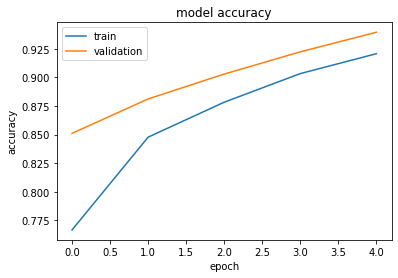

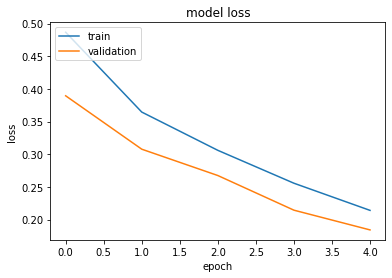

In [18]:
# Plot the model training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Evaluate Model

In [19]:
X_test = tokenizer.texts_to_sequences(df_test['text_a'].values)
X_test = pad_sequences(X_test, maxlen=max_length, 
                        padding=pad_type, truncating=trunc_type)

y_test = df_test['label'].copy()

Accuracy:  0.8535714285714285
Precision:  0.746268656716418
Recall:  0.6364922206506365
F1:  0.6870229007633588
------------------------
Confusion Matrix:


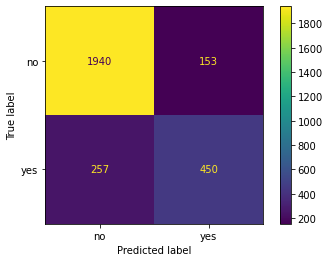

In [20]:
# Predict using the model
y_hat = model.predict(X_test)
pred = np.round(y_hat)

# Evaluate
print("Accuracy: ", accuracy_score(y_test, pred))
print("Precision: ", precision_score(y_test, pred))
print("Recall: ", recall_score(y_test, pred))
print("F1: ", f1_score(y_test, pred))
print('------------------------')
print("Confusion Matrix:")
cm = confusion_matrix(y_test, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no','yes'])
disp.plot()
plt.show()